# Saudi Stock Market — Fundamental Analysis


Fundamental analysis of all 223 TASI-listed stocks covering valuation, profitability, solvency, dividends, and Shariah compliance.

**Data:** CSV fundamentals + live prices from SAHMK API

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import requests, os, warnings
from concurrent.futures import ThreadPoolExecutor
from dotenv import load_dotenv

load_dotenv()
warnings.filterwarnings('ignore')

matplotlib.rcParams['font.family'] = ['Segoe UI', 'Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('dark_background')
sns.set_theme(style='darkgrid')

ModuleNotFoundError: No module named 'pandas'

## 1. Load Data

In [2]:
df = pd.read_csv('data/saudi_stocks_fundamentals.csv')
df['symbol'] = df['symbol'].astype(str)

print(f'{len(df)} stocks across {df["sector_en"].nunique()} sectors')
df.head(10)

223 stocks across 21 sectors


,symbol,name,name_en,sector,sector_en,pe,pb,roe,dividend_yield,debt_equity,net_margin,current_ratio,shariah_debt_ratio,shariah_compliant,revenue_b,net_income_b,total_debt_b,total_assets_b
0,2222,أرامكو السعودية,Saudi Aramco,الطاقة,Energy,15.8,4.2,27.5,6.8,0.25,25.1,1.32,8.2,True,1580.0,398.00,320.00,2650.0
1,1180,الأهلي السعودي,Saudi National Bank,البنوك,Banks,10.2,1.9,18.6,3.5,5.80,42.0,1.05,85.0,False,72.0,30.20,580.00,980.0
2,1120,الراجحي,Al Rajhi Bank,البنوك,Banks,16.5,3.4,22.1,2.8,5.20,48.5,1.08,0.0,True,38.0,18.40,0.00,760.0
3,2010,سابك,SABIC,المواد الأساسية,Materials,42.0,1.3,3.1,2.0,0.55,3.8,1.45,18.5,True,148.0,5.60,65.00,320.0
4,7010,إس تي سي,STC,الاتصالات,Telecom,22.5,3.8,17.2,3.6,0.95,13.5,0.82,28.0,True,73.0,9.80,52.00,185.0
5,2350,كيان السعودية,Kayan Saudi,المواد الأساسية,Materials,0.0,0.9,-2.5,0.0,0.72,-5.2,1.15,22.0,True,12.5,-0.65,8.50,38.0
6,2280,المراعي,Almarai,إنتاج الأغذية,Food Production,22.8,4.5,20.1,2.2,0.65,10.8,0.95,20.5,True,21.5,2.32,9.80,42.0
7,4200,الدريس,Aldrees,التجزئة,Retail,14.5,3.2,22.5,5.5,0.18,4.5,1.25,5.0,True,32.0,1.44,1.20,12.0
8,8210,بوبا العربية,Bupa Arabia,التأمين,Insurance,18.2,5.8,32.5,3.8,0.45,8.2,1.18,12.0,True,18.0,1.48,3.50,28.0
9,3010,أسمنت العربية,Arabian Cement,المواد الأساسية,Materials,19.5,2.1,10.8,4.2,0.08,28.5,2.85,2.5,True,1.2,0.34,0.08,3.8


In [3]:
# fetch live prices — API returns max 50 per request
API_KEY = os.getenv('SAHMK_API_KEY', '')
headers = {'X-API-Key': API_KEY}

symbols = df['symbol'].tolist()
batches = [symbols[i:i+50] for i in range(0, len(symbols), 50)]

def fetch_batch(batch):
    try:
        r = requests.get(f'https://app.sahmk.sa/api/v1/quotes/?symbols={",".join(batch)}',
                        headers=headers, timeout=10)
        return r.json().get('quotes', []) if r.ok else []
    except:
        return []

with ThreadPoolExecutor(max_workers=5) as ex:
    results = list(ex.map(fetch_batch, batches))

all_quotes = [q for batch in results for q in batch]

if all_quotes:
    live = pd.DataFrame(all_quotes)[['symbol','price','change','change_percent','volume']]
    live['symbol'] = live['symbol'].astype(str)
    df = df.merge(live, on='symbol', how='left')
    print(f'Fetched {len(live)} live prices')
else:
    df['price'] = df['change'] = df['change_percent'] = df['volume'] = None
    print('No live data available, using CSV only')

Fetched 220 live prices


In [4]:
# market summary
r = requests.get('https://app.sahmk.sa/api/v1/market/summary/', headers=headers, timeout=10)
if r.ok:
    m = r.json()
    print(f"TASI Index: {m['index_value']:,.2f}  ({m['index_change']:+.2f}, {m['index_change_percent']:+.1f}%)")
    print(f"Market Mood: {m['market_mood']}")
    print(f"Advancing: {m['advancing']}  |  Declining: {m['declining']}  |  Unchanged: {m['unchanged']}")

TASI Index: 11,158.50  (-25.35, -0.2%)
Market Mood: moderately_bearish
Advancing: 69  |  Declining: 191  |  Unchanged: 10


In [5]:
# dataset overview
print(f'Total stocks: {len(df)}')
print(f'Sectors: {df["sector_en"].nunique()}')
print(f'Shariah compliant: {df["shariah_compliant"].sum()}/{len(df)} ({df["shariah_compliant"].mean()*100:.0f}%)')
print(f'Loss-making (negative ROE): {(df["roe"] < 0).sum()}')
print(f'Avg dividend yield: {df["dividend_yield"].mean():.1f}%')
print(f'Avg ROE: {df["roe"].mean():.1f}%')
print(f'Avg P/E (profitable only): {df[df["pe"]>0]["pe"].mean():.1f}')
print(f'Total market revenue: {df["revenue_b"].sum():.0f}B SAR')
print()
df.describe().round(2)

Total stocks: 223
Sectors: 21
Shariah compliant: 209/223 (94%)
Loss-making (negative ROE): 31
Avg dividend yield: 3.0%
Avg ROE: 11.5%
Avg P/E (profitable only): 19.3
Total market revenue: 2924B SAR



,pe,pb,roe,dividend_yield,debt_equity,net_margin,current_ratio,shariah_debt_ratio,revenue_b,net_income_b,total_debt_b,total_assets_b,price,change,change_percent,volume
count,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.00,208.00,220.00,220.00,220.00
mean,16.61,2.75,11.51,2.97,0.68,13.03,1.35,12.95,13.11,2.58,12.24,41.77,35.89,-0.22,-0.46,773377.44
std,10.07,2.40,10.99,1.91,1.05,17.57,0.55,9.69,106.36,26.75,59.03,204.97,60.45,1.58,1.58,2719848.96
min,0.00,0.60,-18.00,0.00,0.03,-40.00,0.55,0.00,0.12,-6.50,0.00,0.15,1.87,-18.10,-8.01,0.00
25%,12.65,1.30,6.50,1.90,0.28,6.00,1.05,7.50,0.68,0.08,0.08,1.20,9.00,-0.25,-1.23,48777.00
50%,16.00,2.00,12.00,3.00,0.40,10.00,1.25,11.00,2.00,0.19,0.50,4.00,17.36,-0.04,-0.42,168761.50
75%,21.50,3.20,17.00,4.00,0.55,20.00,1.55,16.00,5.50,0.48,1.50,11.25,35.44,0.00,0.00,567196.75
max,85.00,15.00,62.00,7.50,5.80,56.00,4.20,85.00,1580.00,398.00,580.00,2650.00,677.00,6.30,9.84,32392099.00


## 2. Valuation Multiples — P/E vs P/B

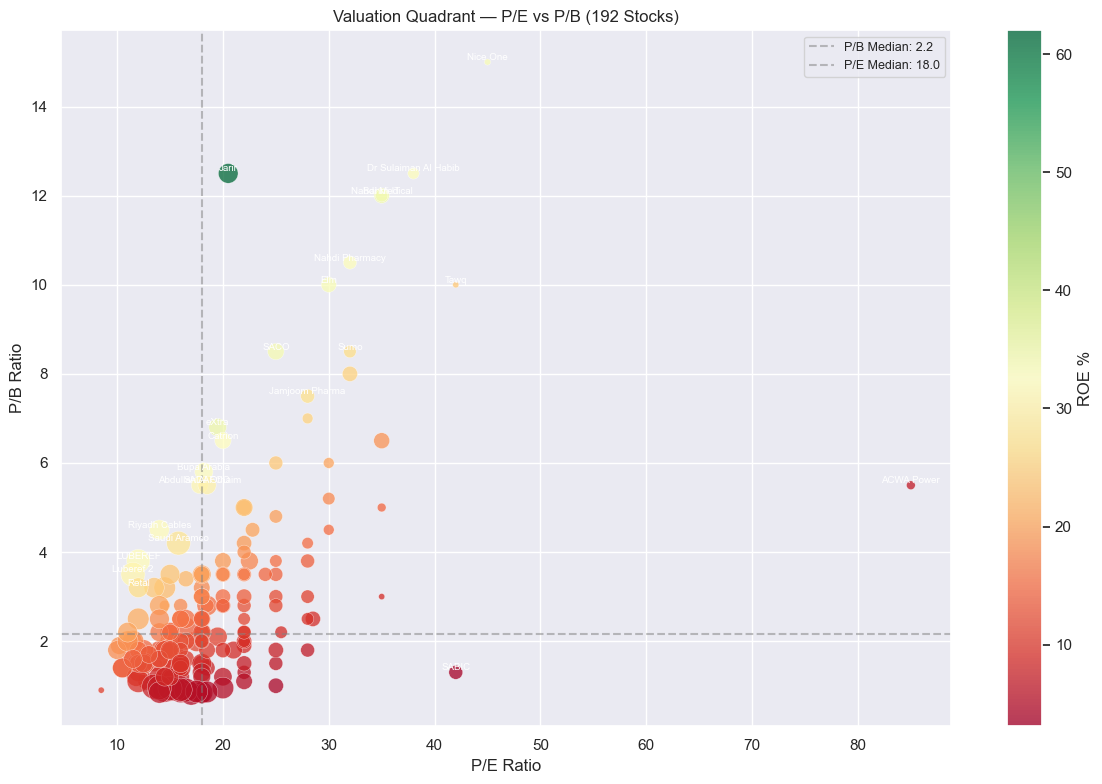

In [6]:
# scatter plot — bubble size = dividend yield, color = ROE
pos = df[df['pe'] > 0].copy()

fig, ax = plt.subplots(figsize=(12, 8))
sc = ax.scatter(pos['pe'], pos['pb'], s=pos['dividend_yield']*40+20,
                c=pos['roe'], cmap='RdYlGn', alpha=0.75,
                edgecolors='white', linewidth=0.3)

# label notable outliers
for _, r in pos[(pos['roe']>25)|(pos['pe']>35)|(pos['pb']>8)].iterrows():
    ax.annotate(r['name_en'], (r['pe'], r['pb']), fontsize=7, color='white', ha='center', va='bottom')

ax.axhline(pos['pb'].median(), color='gray', ls='--', alpha=.5, label=f'P/B Median: {pos["pb"].median():.1f}')
ax.axvline(pos['pe'].median(), color='gray', ls='--', alpha=.5, label=f'P/E Median: {pos["pe"].median():.1f}')
plt.colorbar(sc, ax=ax, label='ROE %')
ax.set(xlabel='P/E Ratio', ylabel='P/B Ratio',
       title=f'Valuation Quadrant — P/E vs P/B ({len(pos)} Stocks)')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig('data/valuation_scatter.png', dpi=100)
plt.show()

In [7]:
# potentially undervalued stocks — below median P/E & P/B with positive ROE
cheap = pos[(pos['pe'] < pos['pe'].median()) &
            (pos['pb'] < pos['pb'].median()) &
            (pos['roe'] > 0)].sort_values('roe', ascending=False)

print(f'Potentially undervalued: {len(cheap)} stocks\n')
print(cheap[['symbol','name_en','sector_en','pe','pb','roe','dividend_yield']].to_string(index=False))

Potentially undervalued: 69 stocks

symbol                name_en         sector_en   pe   pb  roe  dividend_yield
  1180    Saudi National Bank             Banks 10.2 1.90 18.6             3.5
  8060                  Walaa         Insurance 11.0 2.00 18.2             5.0
  8030                MedGulf         Insurance 10.0 1.80 18.0             4.0
  4110                  Bawan     Capital Goods 11.5 2.00 17.5             5.5
  1010             Riyad Bank             Banks 11.5 2.00 17.5             3.8
  4346       Saudi Solidarity         Insurance 12.0 1.80 15.0             3.5
  2320             Al Babtain     Capital Goods 12.5 1.80 14.5             5.0
  4030                  Bahri         Transport 11.5 1.60 14.2             5.0
  8300               Wataniya         Insurance 11.5 1.60 14.0             4.0
  1080     Arab National Bank             Banks 10.5 1.40 13.8             4.5
  1060                   SABB             Banks 12.8 1.70 13.5             3.2
  8280          

## 3. Profitability — ROE & Net Margin

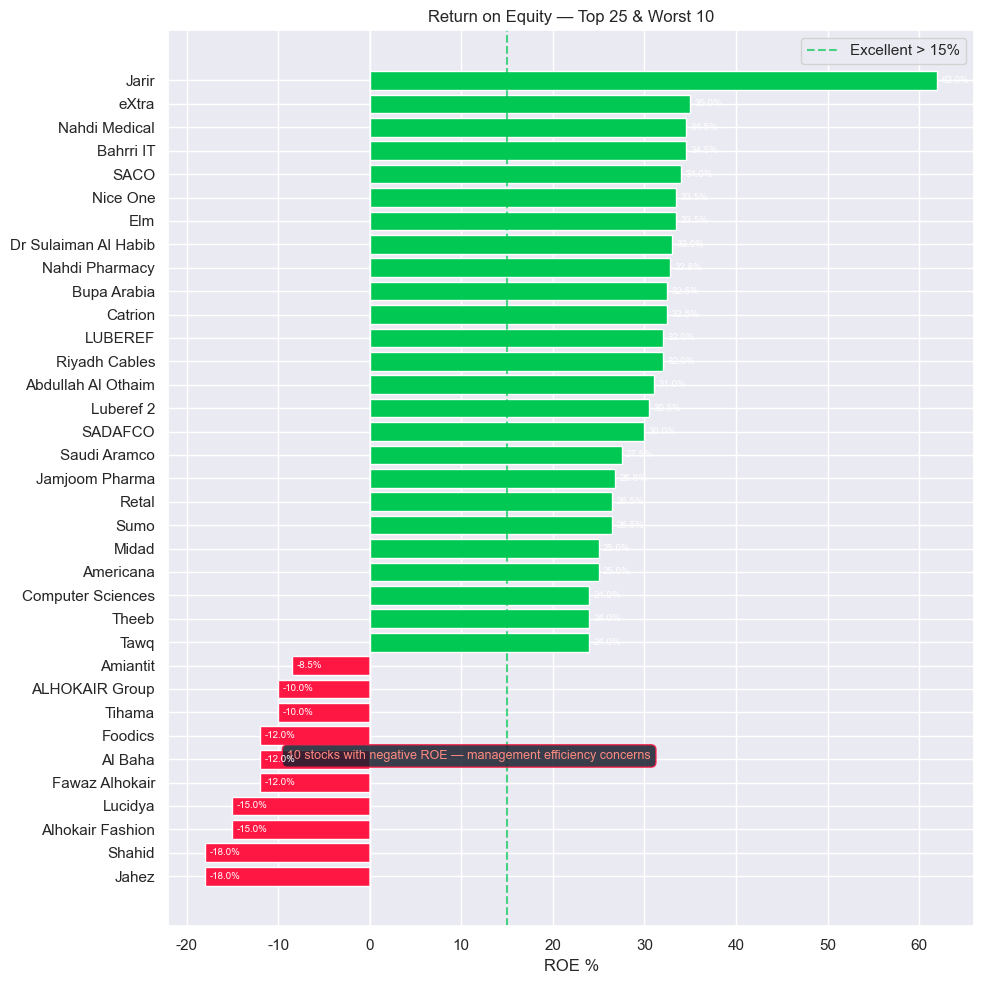

In [8]:
# top 25 best + worst 10 by ROE
best = df.nlargest(25, 'roe')
worst = df[df['roe'] < 0].nsmallest(10, 'roe')
roe_df = pd.concat([worst, best]).drop_duplicates('symbol').sort_values('roe')

colors = ['#FF1744' if x < 0 else '#FFD54F' if x < 15 else '#00C853' for x in roe_df['roe']]

fig, ax = plt.subplots(figsize=(10, 10))
bars = ax.barh(roe_df['name_en'], roe_df['roe'], color=colors)

ax.axvline(15, color='#00C853', ls='--', alpha=.7, label='Excellent > 15%')
ax.axvline(0, color='white', lw=1.5, alpha=.6)

# annotation for negative ROE stocks
neg_count = (roe_df['roe'] < 0).sum()
if neg_count > 0:
    ax.annotate(f'{neg_count} stocks with negative ROE — management efficiency concerns',
                xy=(roe_df['roe'].min()*0.5, neg_count/2),
                fontsize=9, color='#FF8A80',
                bbox=dict(boxstyle='round,pad=0.4', fc='#1A1F2E', ec='#FF1744', alpha=0.85))

for b, v in zip(bars, roe_df['roe']):
    ax.text(b.get_width()+0.5, b.get_y()+b.get_height()/2, f'{v:.1f}%', va='center', fontsize=7, color='white')

ax.set(xlabel='ROE %', title='Return on Equity — Top 25 & Worst 10')
ax.legend()
plt.tight_layout()
plt.savefig('data/roe_comparison.png', dpi=100)
plt.show()

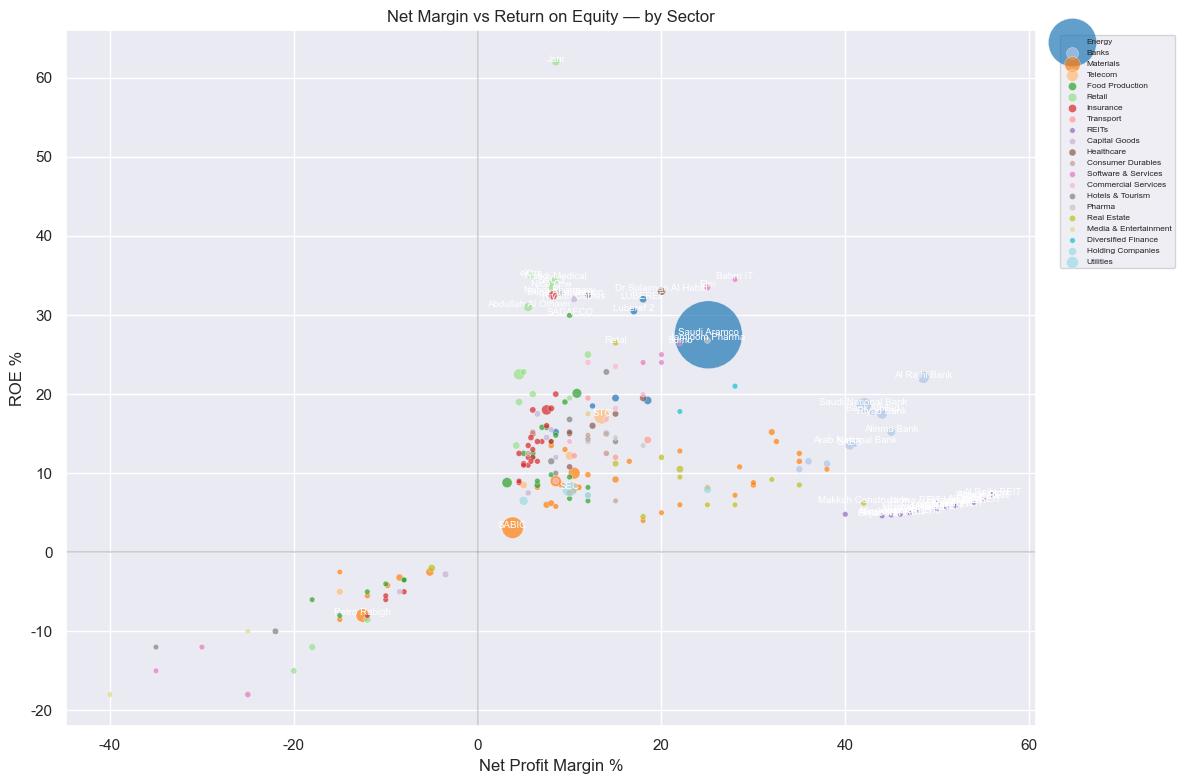

In [9]:
# net margin vs ROE scatter — colored by sector, sized by revenue
fig, ax = plt.subplots(figsize=(12, 8))
sectors = df['sector_en'].unique()
cm = plt.cm.get_cmap('tab20', len(sectors))

for i, sec in enumerate(sectors):
    sub = df[df['sector_en'] == sec]
    ax.scatter(sub['net_margin'], sub['roe'], s=sub['revenue_b']*1.5+15,
               color=cm(i), alpha=.7, label=sec, edgecolors='w', linewidth=.3)

for _, r in df[(df['roe']>25)|(df['net_margin']>40)|(df['revenue_b']>50)].iterrows():
    ax.annotate(r['name_en'], (r['net_margin'], r['roe']), fontsize=7, color='white', ha='center')

ax.axhline(0, color='gray', alpha=.3)
ax.axvline(0, color='gray', alpha=.3)
ax.set(xlabel='Net Profit Margin %', ylabel='ROE %',
       title='Net Margin vs Return on Equity — by Sector')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=6)
plt.tight_layout()
plt.savefig('data/margin_vs_roe.png', dpi=100)
plt.show()

## 4. Shariah Compliance Screening

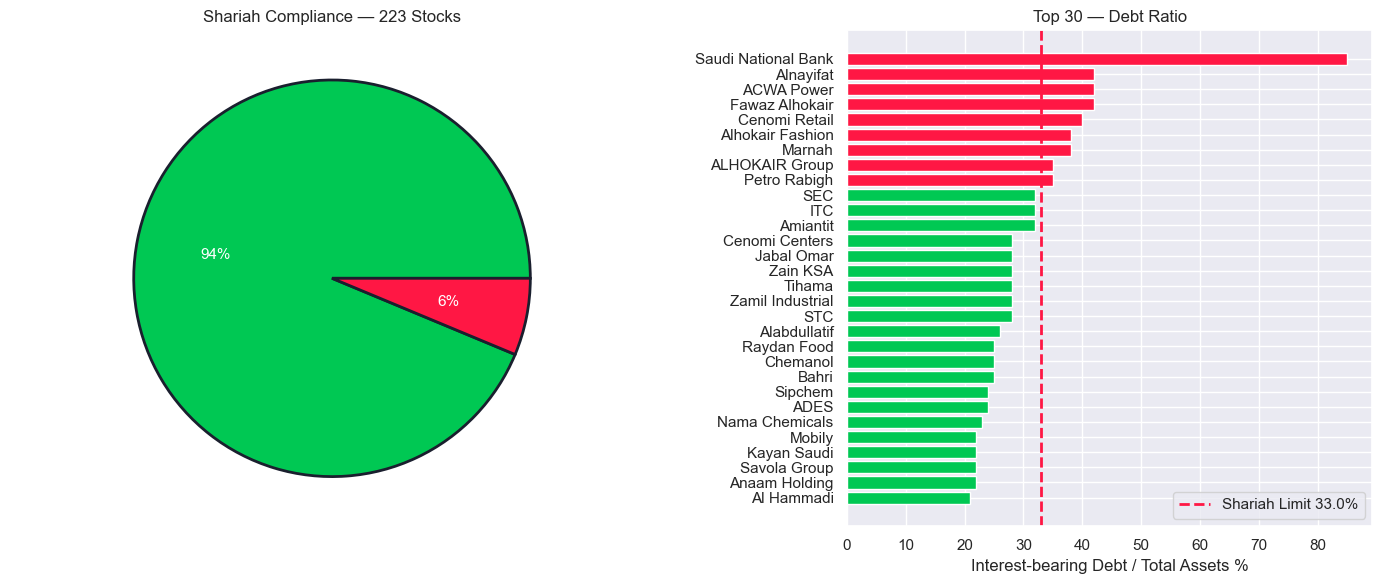

In [10]:
# Shariah screening — interest-bearing debt must be < 33% of total assets
LIMIT = 33.0

compliant = df['shariah_compliant'].sum()
non_compliant = len(df) - compliant

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# pie chart
ax1.pie([compliant, non_compliant],
        labels=[f'Compliant ({compliant})', f'Non-compliant ({non_compliant})'],
        colors=['#00C853','#FF1744'], autopct='%1.0f%%',
        textprops={'fontsize':11, 'color':'white'},
        wedgeprops={'edgecolor':'#1A1F2E', 'linewidth':2})
ax1.set_title(f'Shariah Compliance — {len(df)} Stocks')

# top 30 by debt ratio
top_debt = df.nlargest(30, 'shariah_debt_ratio').sort_values('shariah_debt_ratio')
clrs = ['#00C853' if x < LIMIT else '#FF1744' for x in top_debt['shariah_debt_ratio']]
ax2.barh(top_debt['name_en'], top_debt['shariah_debt_ratio'], color=clrs)
ax2.axvline(LIMIT, color='#FF1744', ls='--', lw=2, label=f'Shariah Limit {LIMIT}%')
ax2.set(xlabel='Interest-bearing Debt / Total Assets %',
        title='Top 30 — Debt Ratio')
ax2.legend()

plt.tight_layout()
plt.savefig('data/shariah_screening.png', dpi=100)
plt.show()

In [11]:
# shariah-compliant stocks ranked by dividend yield
shariah = df[df['shariah_compliant']].sort_values('dividend_yield', ascending=False)
print(f'{len(shariah)} Shariah-compliant stocks\n')
print(shariah[['symbol','name_en','sector_en','shariah_debt_ratio','dividend_yield','roe','pe']].head(30).to_string(index=False))

209 Shariah-compliant stocks

symbol             name_en     sector_en  shariah_debt_ratio  dividend_yield  roe   pe
  4336       Al Rajhi REIT         REITs                12.0             7.5  7.3 13.5
  4340         Alawal REIT         REITs                12.5             7.2  6.9 14.0
  4321         Riyadh REIT         REITs                15.0             7.2  6.8 14.0
  4337        Alaahli REIT         REITs                13.0             7.0  6.3 15.0
  4324         Bonyan REIT         REITs                13.0             7.0  6.2 14.5
  9530           Luberef 2        Energy                14.0             7.0 30.5 11.5
  2222        Saudi Aramco        Energy                 8.2             6.8 27.5 15.8
  4334         Mulkia REIT         REITs                14.0             6.8  5.5 16.5
  4322 Jadwa REIT Haramain         REITs                16.0             6.8  6.2 15.0
  4031             LUBEREF        Energy                15.0             6.5 32.0 12.0
  4310      M

## 5. Financial Solvency — Debt & Liquidity

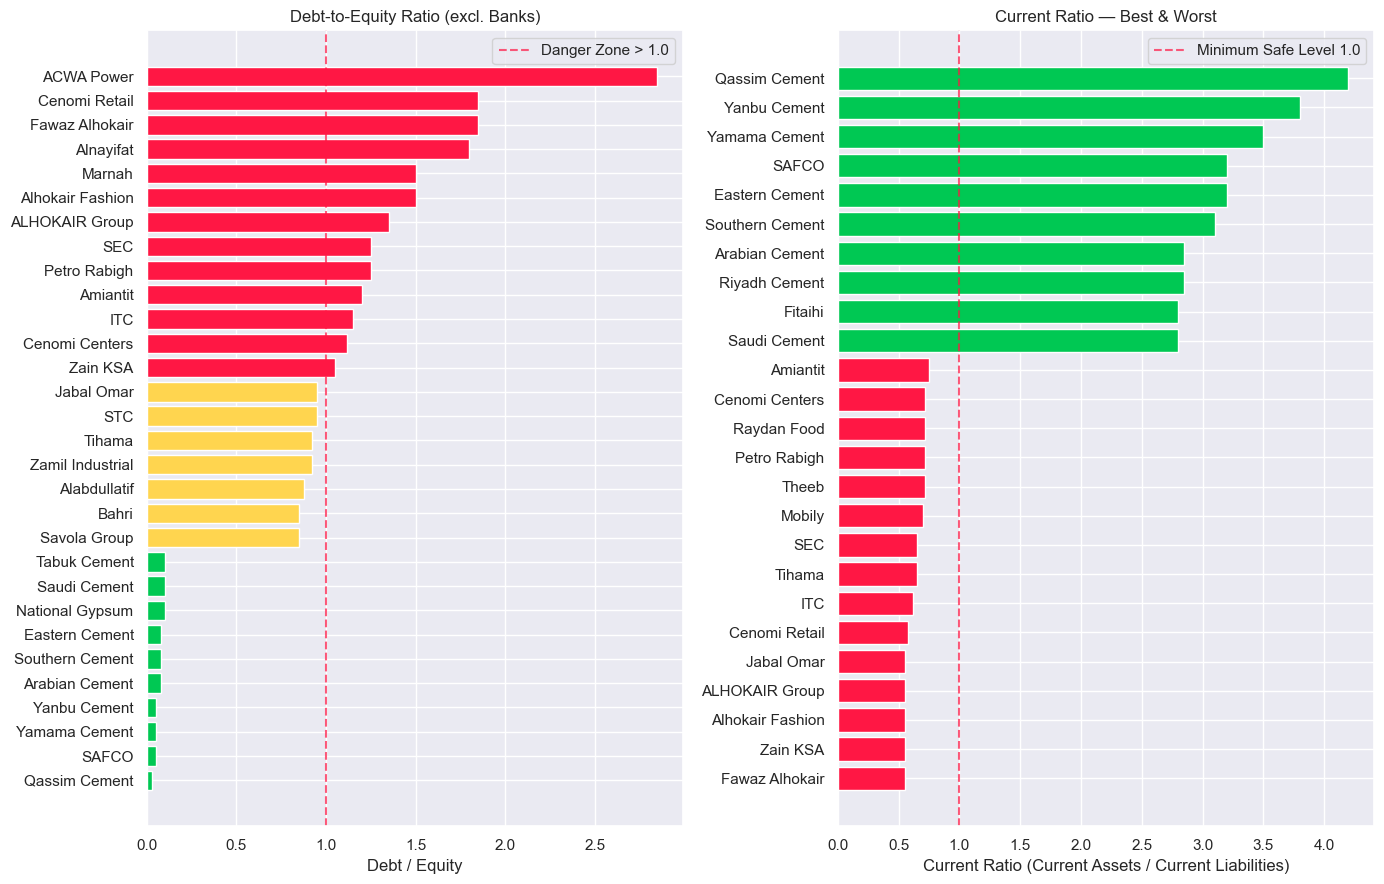

In [12]:
# excluding banks — their high leverage is structural, not a red flag
nobank = df[df['sector_en'] != 'Banks']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))

# debt-to-equity
de = pd.concat([nobank.nsmallest(10,'debt_equity'),
                nobank.nlargest(20,'debt_equity')]).drop_duplicates('symbol').sort_values('debt_equity')
ax1.barh(de['name_en'], de['debt_equity'],
         color=['#00C853' if x<.5 else '#FFD54F' if x<1 else '#FF1744' for x in de['debt_equity']])
ax1.axvline(1.0, color='#FF1744', ls='--', alpha=.7, label='Danger Zone > 1.0')
ax1.set(xlabel='Debt / Equity', title='Debt-to-Equity Ratio (excl. Banks)')
ax1.legend()

# current ratio
cr = pd.concat([df.nsmallest(15,'current_ratio'),
                df.nlargest(10,'current_ratio')]).drop_duplicates('symbol').sort_values('current_ratio')
ax2.barh(cr['name_en'], cr['current_ratio'],
         color=['#FF1744' if x<1 else '#FFD54F' if x<1.5 else '#00C853' for x in cr['current_ratio']])
ax2.axvline(1.0, color='#FF1744', ls='--', alpha=.7, label='Minimum Safe Level 1.0')
ax2.set(xlabel='Current Ratio (Current Assets / Current Liabilities)',
        title='Current Ratio — Best & Worst')
ax2.legend()

plt.tight_layout()
plt.savefig('data/solvency_analysis.png', dpi=100)
plt.show()

## 6. Dividend Yield

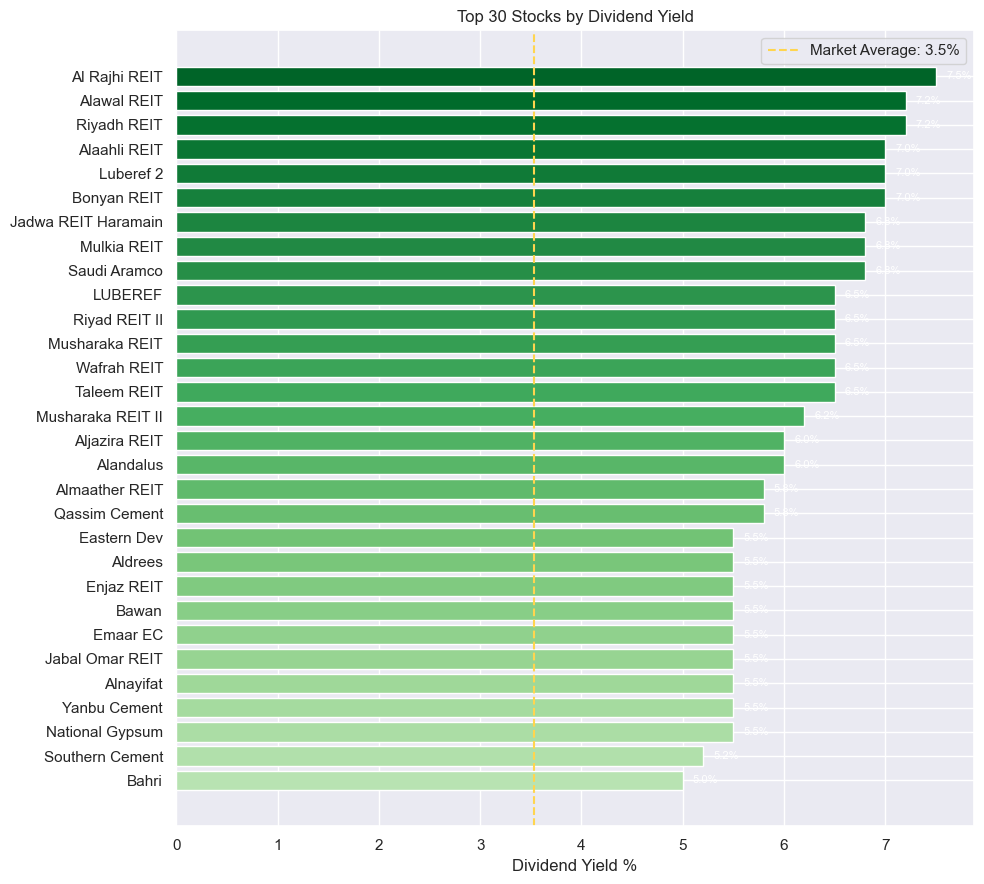

In [13]:
# top 30 dividend payers
divs = df[df['dividend_yield']>0].nlargest(30,'dividend_yield').sort_values('dividend_yield')
avg_div = df[df['dividend_yield']>0]['dividend_yield'].mean()

fig, ax = plt.subplots(figsize=(10, 9))
ax.barh(divs['name_en'], divs['dividend_yield'],
        color=plt.cm.Greens(np.linspace(.3,.9,len(divs))))

for b, v in zip(ax.patches, divs['dividend_yield']):
    ax.text(b.get_width()+.1, b.get_y()+b.get_height()/2, f'{v:.1f}%', va='center', fontsize=8, color='white')

ax.axvline(avg_div, color='#FFD54F', ls='--', label=f'Market Average: {avg_div:.1f}%')
ax.set(xlabel='Dividend Yield %', title='Top 30 Stocks by Dividend Yield')
ax.legend()
plt.tight_layout()
plt.savefig('data/dividend_yield.png', dpi=100)
plt.show()

## 7. Revenue vs Net Income

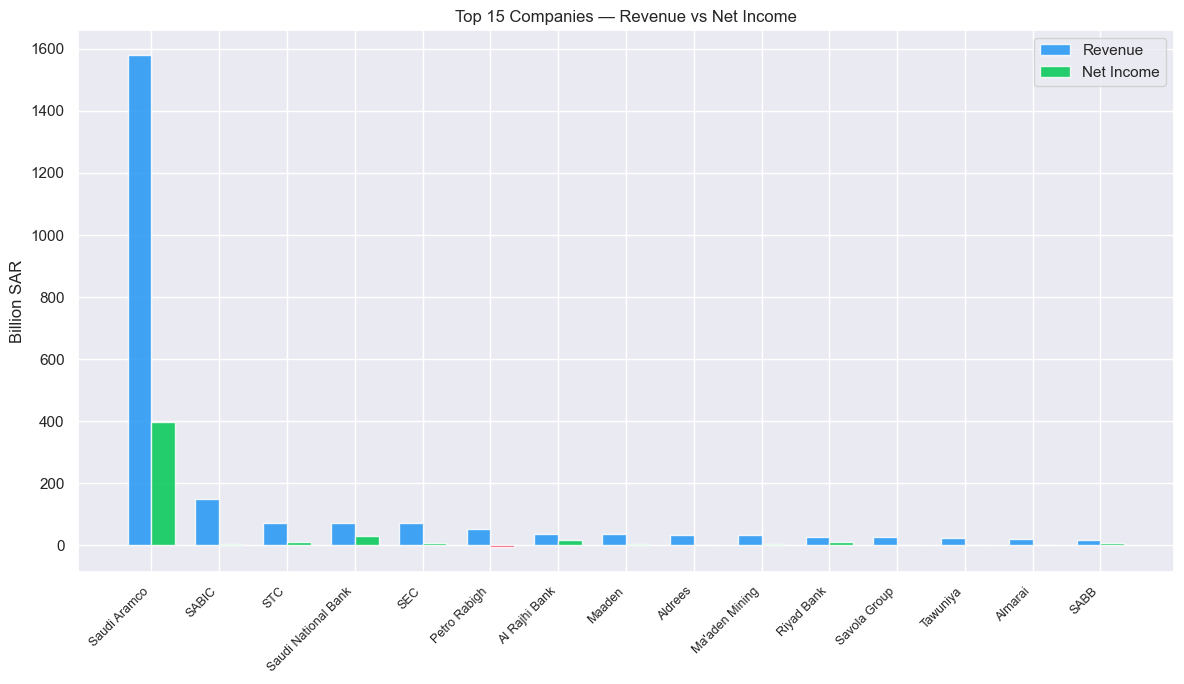

In [14]:
# top 15 companies by revenue
top15 = df.nlargest(15, 'revenue_b')

fig, ax = plt.subplots(figsize=(12, 7))
x = np.arange(len(top15))
w = 0.35
ax.bar(x-w/2, top15['revenue_b'], w, label='Revenue', color='#2196F3', alpha=.85)
ax.bar(x+w/2, top15['net_income_b'], w, label='Net Income',
       color=['#00C853' if v>0 else '#FF1744' for v in top15['net_income_b']], alpha=.85)

ax.set_xticks(x)
ax.set_xticklabels(top15['name_en'], rotation=45, ha='right', fontsize=9)
ax.set(ylabel='Billion SAR', title='Top 15 Companies — Revenue vs Net Income')
ax.legend()
plt.tight_layout()
plt.savefig('data/revenue_vs_profit.png', dpi=100)
plt.show()

## 8. Correlation Matrix

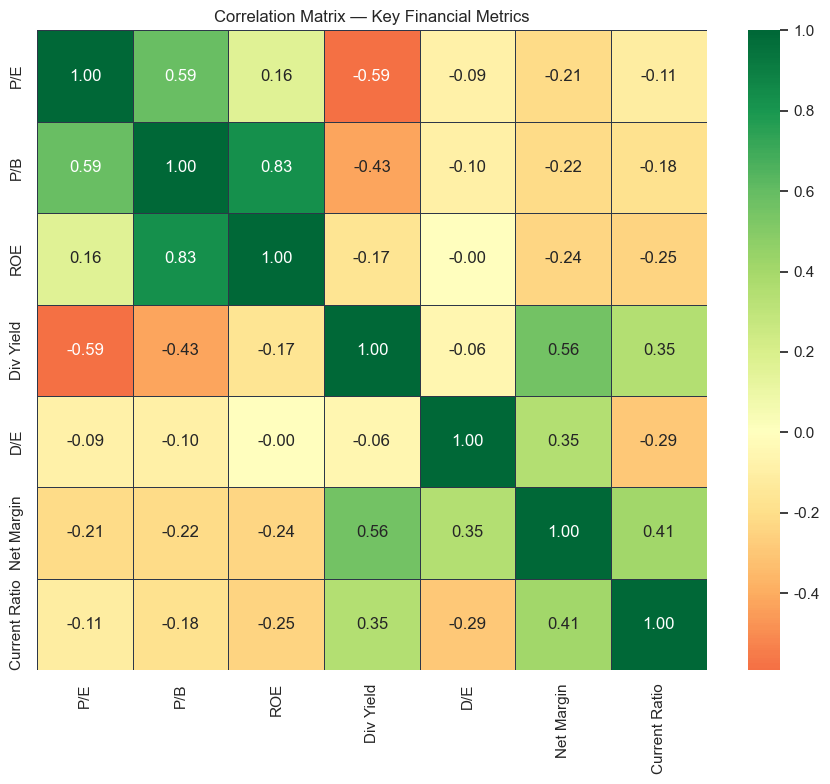

In [15]:
cols = ['pe','pb','roe','dividend_yield','debt_equity','net_margin','current_ratio']
labels = ['P/E', 'P/B', 'ROE', 'Div Yield', 'D/E', 'Net Margin', 'Current Ratio']

corr = df[df['pe']>0][cols].corr()

fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            xticklabels=labels, yticklabels=labels, ax=ax,
            linewidths=.5, linecolor='#2D3748')
ax.set_title('Correlation Matrix — Key Financial Metrics')
plt.tight_layout()
plt.savefig('data/correlation_matrix.png', dpi=100)
plt.show()

## 9. Sector Comparison

In [16]:
sector_avg = df.groupby('sector_en').agg(
    stocks=('symbol','count'),
    avg_roe=('roe','mean'),
    avg_pe=('pe', lambda x: x[x>0].mean() if (x>0).any() else 0),
    avg_div=('dividend_yield','mean'),
    avg_de=('debt_equity','mean'),
    avg_margin=('net_margin','mean'),
    total_rev=('revenue_b','sum')
).round(2).sort_values('avg_roe', ascending=False)

sector_avg

,stocks,avg_roe,avg_pe,avg_div,avg_de,avg_margin,total_rev
sector_en,,,,,,,
Energy,7,23.20,17.61,4.37,0.45,16.37,1624.60
Retail,16,21.05,24.10,2.45,0.61,2.53,143.50
Pharma,6,19.43,25.67,2.05,0.32,15.50,20.25
Diversified Finance,2,19.40,15.00,4.25,1.65,25.00,1.30
Commercial Services,9,17.44,20.17,2.81,0.42,12.72,12.72
Healthcare,9,17.37,27.89,1.58,0.52,13.50,39.50
Banks,10,15.17,12.96,3.35,5.22,41.30,216.50
Transport,4,14.48,15.62,3.62,0.60,14.00,17.70
Software & Services,9,13.61,32.00,1.06,0.24,4.78,11.05


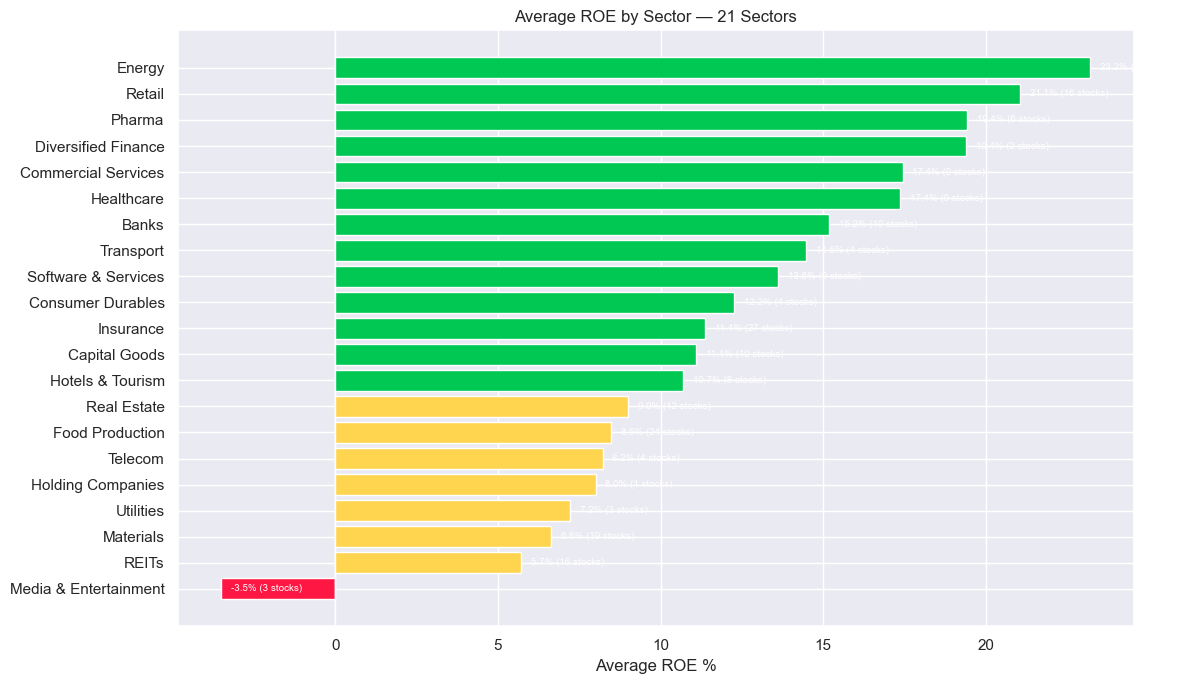

In [17]:
# sector ROE comparison
fig, ax = plt.subplots(figsize=(12, 7))
s = sector_avg.sort_values('avg_roe')
ax.barh(s.index, s['avg_roe'],
        color=['#FF1744' if x<0 else '#FFD54F' if x<10 else '#00C853' for x in s['avg_roe']])

for i, (v, n) in enumerate(zip(s['avg_roe'], s['stocks'])):
    ax.text(v+.3, i, f'{v:.1f}% ({n} stocks)', va='center', fontsize=7, color='white')

ax.axvline(0, color='white', alpha=.3)
ax.set(xlabel='Average ROE %', title=f'Average ROE by Sector — {len(sector_avg)} Sectors')
plt.tight_layout()
plt.savefig('data/sector_roe.png', dpi=100)
plt.show()

## 10. Export

In [18]:
df.to_csv('data/saudi_stocks_enriched.csv', index=False, encoding='utf-8-sig')
print(f'Exported {len(df)} stocks to data/saudi_stocks_enriched.csv')
print(f'Columns: {list(df.columns)}')

Exported 223 stocks to data/saudi_stocks_enriched.csv
Columns: ['symbol', 'name', 'name_en', 'sector', 'sector_en', 'pe', 'pb', 'roe', 'dividend_yield', 'debt_equity', 'net_margin', 'current_ratio', 'shariah_debt_ratio', 'shariah_compliant', 'revenue_b', 'net_income_b', 'total_debt_b', 'total_assets_b', 'price', 'change', 'change_percent', 'volume']


## Key Findings

- **Shariah compliance**: Majority of TASI stocks are Shariah-compliant — well-suited for Tarmeez Capital's investment portfolios
- **Top dividends**: REITs lead with 7%+ yields, followed by Saudi Aramco (6.8%) and Luberef
- **Best ROE performers**: Jarir Marketing (62%), Bahr Al Arab (34.5%), Bupa Arabia (32.5%)
- **Strongest sector**: Banks lead profitability with avg ROE ~16%, but are excluded from Shariah screening
- **Red flags**: Several Materials and Technology companies show negative ROE, indicating management efficiency issues
- **Coverage**: 223 stocks across 21 sectors fully analyzed